In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
import math
os.getcwd()
plt.style.use('ggplot')
import numba
import datetime

In [3]:
# These are the Poison Processes that model order arrivals.
# Both are decreasing functions of the distance between limit order and 
# current midprice.

# Poisson process for bids (models buy order arrival)
# Input is distance between limit order and current midprice
@numba.jit(nopython=True)
def hit_rate(dist_a):
    return (mkt_freq/alpha)*np.exp(-1*k*dist_a)   

# Poisson process for offers (models sell order arrival)
# Input is distance between limit order and current midprice
@numba.jit(nopython=True)
def lift_rate(dist_b): 
    return (mkt_freq/alpha)*np.exp(-1*k*dist_b)

In [4]:
# Reservation Price (highest price a buyer is willing to buy for/lowest price 
# a seller is willing to sell for)
@numba.jit(nopython=True)
def res(s,t,q,sigma):
    return s - (q*gamma*(sigma**2)*(T-t))

In [5]:
# Bid-Ask Price (dependent on risk aversion as well as standard deviation of 
# movement in the underlying)
# r: reservation price 
@numba.jit(nopython=True)
def bid_price(r,t,sigma):
    return r - .5*(gamma*(sigma**2)*(T-t)+(2/gamma)*np.log(1+(gamma/k)))

@numba.jit(nopython=True)
def ask_price(r,t,sigma):
    return r + .5*(gamma*(sigma**2)*(T-t)+(2/gamma)*np.log(1+(gamma/k)))

## MC Simulation with constant time increment


In [6]:
# Simulate enough times to have confidence in our results
num_iterations=1000000

# Global vars

#PP rate params
mkt_freq = 200      # frequency of market buy or sell orders (avg order size)
alpha = 1.4         # Value for US Stocks assuming distribution of the size 
                    # of market orders to obey a power law (Maslow and Mills 2001)
k = 1.5

#simulation params
s = 100 # Price of the Underlying
t = 0 # Starting time
T = 1 # Total time
sigma = 2 # St deviation on movement of the underlying
dt = .001 # Change in time between intervals

gamma = .1 #risk aversion

# Starting inventory and wealth 
q = 0  # inventory
w = 0  # wealth

In [7]:
@numba.jit(nopython=True)
def simulate1(skew): #Skew tells us whether or not to use reservation price  
    # Arrays to store results across iterations
    avg_wealths = np.zeros(num_iterations)
    terminal_wealths = np.zeros(num_iterations)
    avg_mkt_sizes = np.zeros(num_iterations)
    avg_inventory = np.zeros(num_iterations)
    terminal_inv = np.zeros(num_iterations)

    for i in range(num_iterations):
      
        q = 0 # inventory
        w = 0 # wealth
        s = 100 # Current price of underlying (midprice)
        t = 0 # Current time

        mkt_size = np.zeros(int(T/dt)) # Array whose length corresponds with number of time periods in simulation 
        wealth = np.zeros(int(T/dt)) # wealth at each time period during simulation
        inv = np.zeros(int(T/dt)) # inventory at each time period during simulation
        
        j = 0 # Index for current location in arrays defined above

        
        while t<T:
            if skew:
                r = res(s,t,q,sigma)
            else:
                r = s
                
            b = bid_price(r,t,sigma)
            a = ask_price(r,t,sigma)


            U_b = np.random.uniform(0,1)
            U_a = np.random.uniform(0,1)

            # Determine whether to buy or sell
            # RHS of inequality is the PP rate normalized to be on [0,1]
            if U_b < (hit_rate(s-b)/hit_rate(0)):  # you bought 
                q+=1
                w+=(s-b) # Collecting spread between bid and midprice

            if U_a < (lift_rate(a-s)/lift_rate(0)):  # you sold 
                q-=1
                w+=(a-s) # Collecting spread between ask and midprice

            t+=dt

            # Stock price update (Brownian motion assumed)
            U_s = np.random.uniform(0,1)
            if (U_s<=.5):
                s+=(sigma*np.sqrt(dt))
            else:
                s-=(sigma*np.sqrt(dt))

            mkt_size[j]= a-b # add spread
            wealth[j] = w # add current wealth
            inv[j] = q # add current inventory
            
            j += 1

        #below forces MM to close out position at end of period 
        if q>0:
            w+=(q*(a-s))
        else:
            w+=(q*(s-b))

        terminal_wealths[i] = w
        terminal_inv[i] = q
        avg_wealths[i] = wealth.mean()
        avg_mkt_sizes[i] = mkt_size.mean()
        avg_inventory[i] = inv.mean()

    return avg_wealths, terminal_wealths, avg_mkt_sizes, avg_inventory, terminal_inv

In [8]:
start = datetime.datetime.now()
avg_wealths, terminal_wealths, avg_mkt_sizes, avg_inventory, terminal_inv = simulate1(skew=True)
end = datetime.datetime.now()
print("processed {} iterations in {}".format(num_iterations , end - start))

processed 1000000 iterations in 0:01:40.798668


In [9]:
start = datetime.datetime.now()
S_avg_wealths, S_terminal_wealths, S_avg_mkt_sizes, S_avg_inventory, S_terminal_inv = simulate1(skew=False)
end = datetime.datetime.now()
print("processed {} iterations in {}".format(num_iterations , end - start))

processed 1000000 iterations in 0:01:36.469200


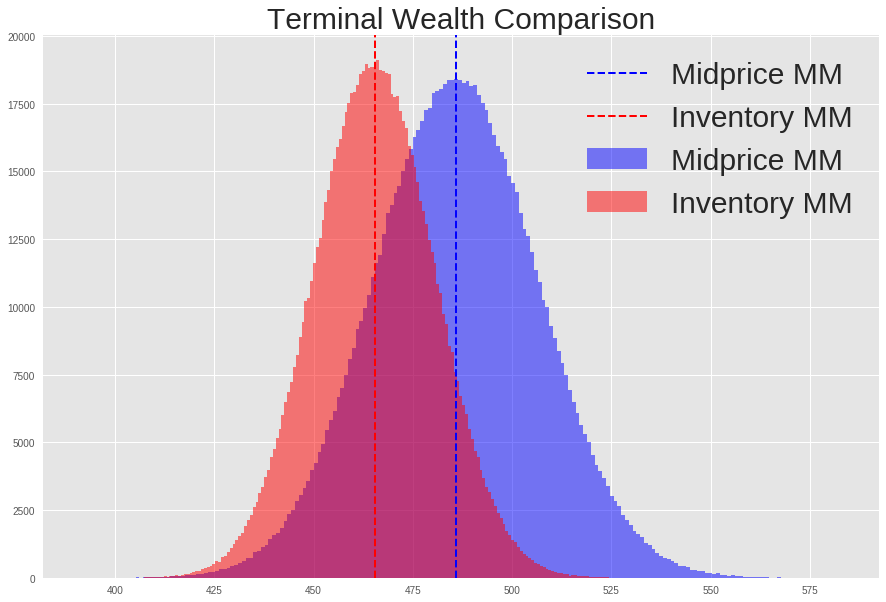

In [10]:
plt.figure(figsize=(15,10))
plt.hist(S_terminal_wealths, bins=200, color='b', alpha=0.5, label='Midprice MM')
plt.axvline(S_terminal_wealths.mean(), color='b', linestyle='dashed', linewidth=2, label='Midprice MM')
plt.hist(terminal_wealths, bins=200, color='r', alpha=0.5, label='Inventory MM')
plt.axvline(terminal_wealths.mean(), color='r', linestyle='dashed', linewidth=2, label='Inventory MM')
plt.legend(fontsize=30)
plt.title('Terminal Wealth Comparison',fontsize=30)
plt.show()

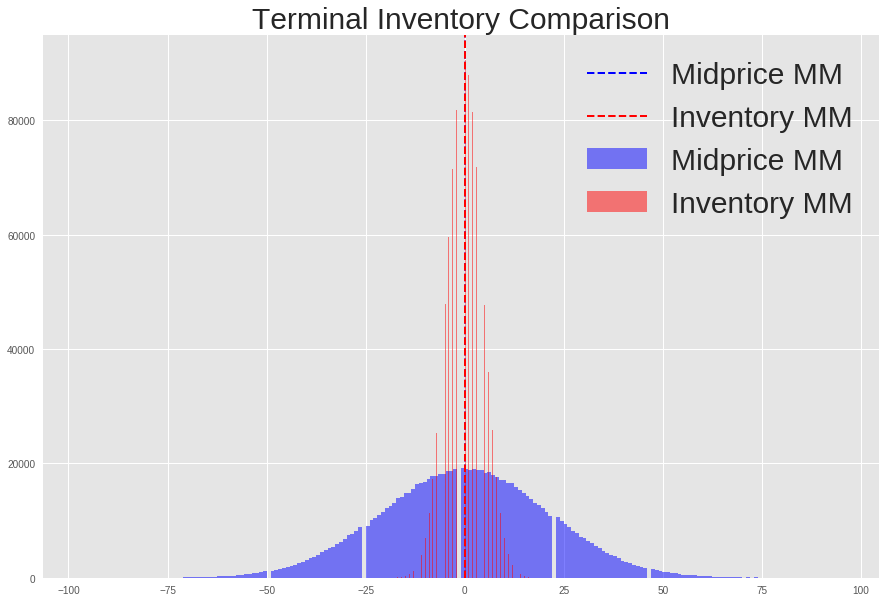

In [11]:
#Assuming that postions are not closed out 
plt.figure(figsize=(15,10))
plt.hist(S_terminal_inv, bins=200, color='b', alpha=0.5, label='Midprice MM')
plt.axvline(S_terminal_inv.mean(), color='b', linestyle='dashed', linewidth=2, label='Midprice MM')
plt.hist(terminal_inv, bins=200, color='r', alpha=0.5, label='Inventory MM')
plt.axvline(terminal_inv.mean(), color='r', linestyle='dashed', linewidth=2, label='Inventory MM')
plt.legend(fontsize=30)
plt.title('Terminal Inventory Comparison',fontsize=30)
plt.show()

In [12]:
print('gamma = '+str(gamma))
print('average spread size = '+str(avg_mkt_sizes.mean()))
print('average final wealth = '+str(terminal_wealths.mean()))
print('average inventory  = '+str(avg_inventory.mean()))

gamma = 0.1
average spread size = 1.4909704227514196
average final wealth = 465.40612855441606
average inventory  = 0.0002467940000000003


Example of Single Simulation

In [13]:
#Global vars

#PP rate params
mkt_freq = 200 
alpha = 1.4         
k = 1.5

#simulation params
T = 1
sigma = 2
dt = .001

#risk aversion
gamma = .1


In [14]:
@numba.jit(nopython=True)
def simulate2():   
    bids = np.zeros(int(T/dt))
    asks = np.zeros(int(T/dt))
    midprices = np.zeros(int(T/dt))
    wealth = np.zeros(int(T/dt))
    inventory = np.zeros(int(T/dt))
    time = np.zeros(int(T/dt))
    res_p = np.zeros(int(T/dt))

    s = 100
    t = 0
    j = 0
    
    #starting inv and wealth 
    q = 0
    w = 0
    
    while(t<T):
        r = res(s,t,q,sigma)
        b = bid_price(r,t,sigma)
        a = ask_price(r,t,sigma)

        #monte carlo sim of hits and lifts
        U_b = np.random.uniform(0,1)
        U_a = np.random.uniform(0,1)

        #the RHS is the PP rate normalized to be on [0,1]
        if U_b < (hit_rate(s-b)/hit_rate(0)):
            q+=1
            w+=(s-b)
        if U_a < (lift_rate(a-s)/lift_rate(0)):
            q-=1
            w+=(a-s)
        t+=dt

        #stock price update (Brownian motion assumed)
        U_s = np.random.uniform(0,1)
        if (U_s<=.5):
            s+=(sigma*np.sqrt(dt))
        else:
            s-=(sigma*np.sqrt(dt))

        #below forces MM to close out position at end of period 
        if q>0:
            w+=(q*(a-s))
        else:
            w+=(q*(s-b))


        #keep memory in arrays for plotting 
        bids[j] = b
        asks[j] = a
        midprices[j] = s
        wealth[j] = w
        inventory[j] = q
        time[j] = t
        res_p[j] = r
        
        j += 1

    return bids, asks, midprices, wealth, inventory, time, res_p

In [15]:
start = datetime.datetime.now()
bids, asks, midprices, wealth, inventory, time, res_p = simulate2()
end = datetime.datetime.now()
print("processed in {}".format(end - start))

processed in 0:00:00.288839


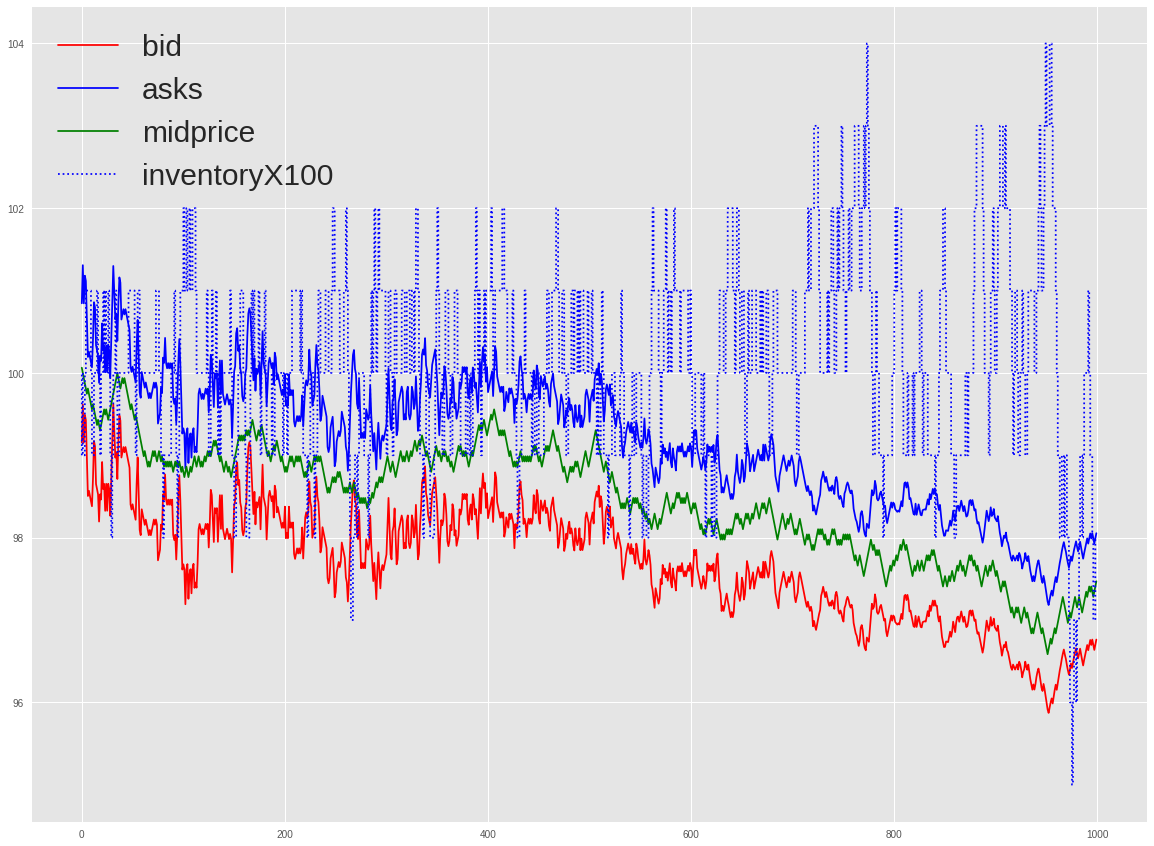

In [16]:
plt.figure(figsize=(20,15))
plt.plot(bids,'r',label='bid')
plt.plot(asks,'b',label='asks')
plt.plot(midprices,'g',label='midprice')
plt.plot([i+100 for i in inventory],'b',drawstyle='steps',linestyle='dotted',label='inventoryX100')
plt.legend(fontsize=30)
plt.show()

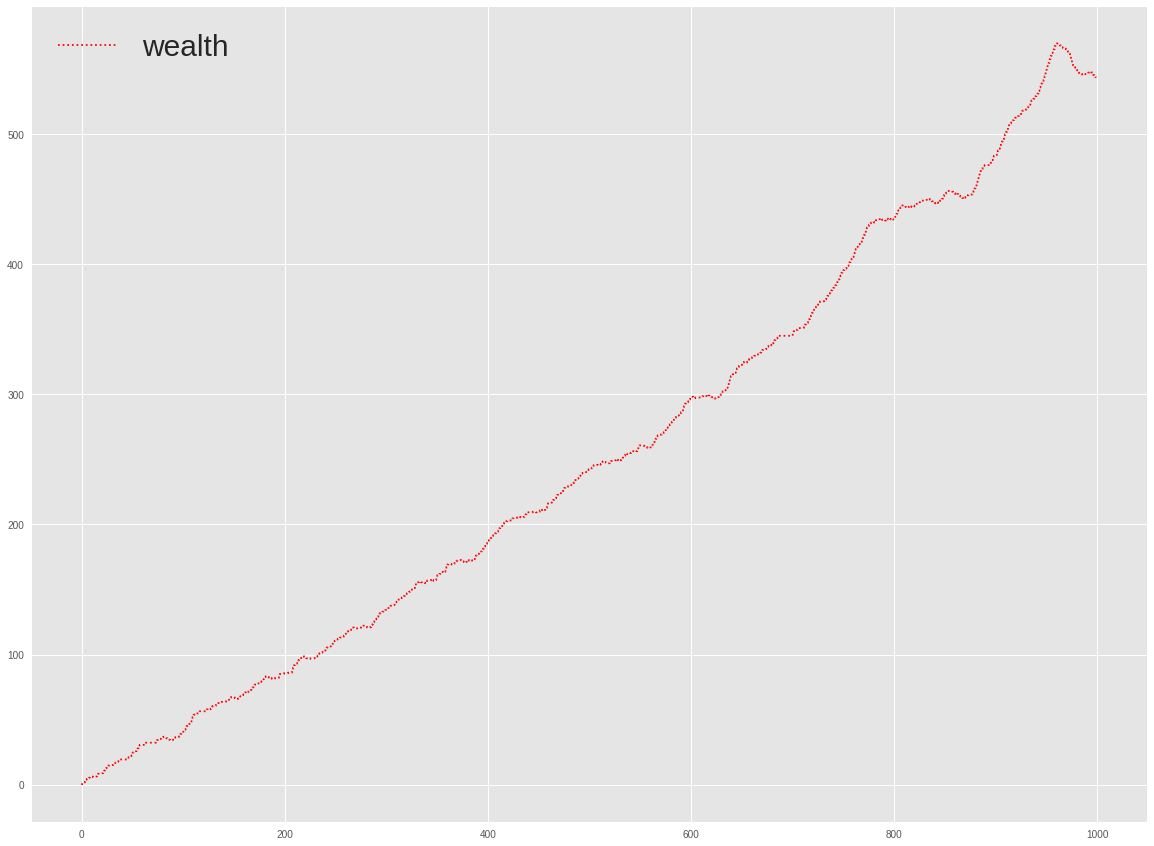

In [17]:
plt.figure(2)
plt.figure(figsize=(20,15))
#plt.plot(inventory,'b')
plt.plot(wealth,'r',drawstyle='steps',linestyle='dotted',label='wealth')
plt.legend(fontsize=30)
plt.show()